In [1]:
import numpy as np
import os
import shutil
import random
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

2025-04-30 18:08:23.286888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746036503.520370      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746036503.586315      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
DATASET_PATH = "/kaggle/input/lung-cancer-histopathological-images"
WORKING_DIR = "/kaggle/working/dataset"
if not os.path.exists(WORKING_DIR):
    shutil.copytree(DATASET_PATH, WORKING_DIR)

In [4]:
classes = ["adenocarcinoma", "benign", "squamous_cell_carcinoma"]

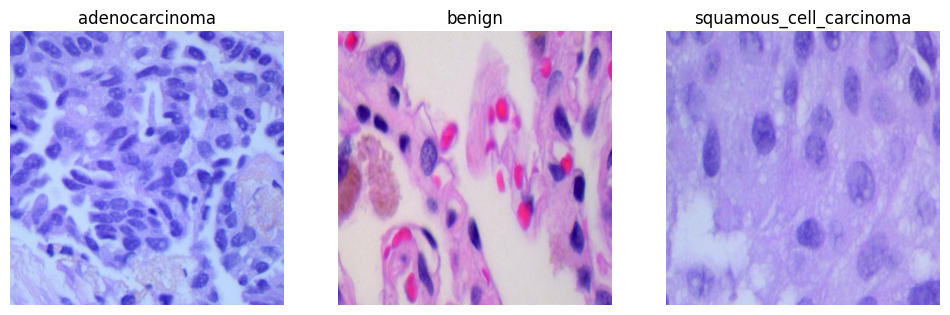

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, label in enumerate(classes):
    img_path = os.path.join(WORKING_DIR, label)
    img_file = random.choice(os.listdir(img_path))
    img = cv2.imread(os.path.join(img_path, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis("off")
plt.show()

In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 1

# Create ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
#    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    shear_range=0.2,
#    zoom_range=0.2,
#    horizontal_flip=True,
#    fill_mode='nearest'
)
# trying squeezenet with basically no augumentation to get a clearer picture
# Load training data
train_data = datagen.flow_from_directory(
    WORKING_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_data = datagen.flow_from_directory(
    WORKING_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [8]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="/kaggle/input/lung_cancer_squeezenet_unaugumented_float16/tflite/default/1/squeezenet_lung_cancer_unaugumented_float16.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("TFLite model loaded successfully!")

TFLite model loaded successfully!


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [9]:
correct = 0
total = 0

for i in range(len(val_data)):
    img, label = val_data[i]
    
    # Preprocess and run inference
    interpreter.set_tensor(input_details[0]['index'], img.astype(np.float32))
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])

    pred = np.argmax(output)
    true = np.argmax(label)

    if pred == true:
        correct += 1
    total += 1

# Accuracy calculation
accuracy = correct / total
print(f"TFLite Model Accuracy: {accuracy * 100:.2f}%")

TFLite Model Accuracy: 98.57%


Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.98      0.98      0.98      1000
                 benign       1.00      1.00      1.00      1000
squamous_cell_carcinoma       0.98      0.98      0.98      1000

               accuracy                           0.99      3000
              macro avg       0.99      0.99      0.99      3000
           weighted avg       0.99      0.99      0.99      3000



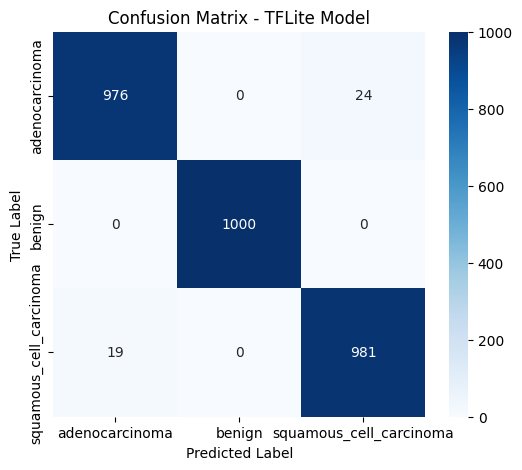

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for i in range(len(val_data)):
    img, label = val_data[i]
    
    interpreter.set_tensor(input_details[0]['index'], img.astype(np.float32))
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])

    pred = np.argmax(output)
    true = np.argmax(label)

    y_pred.append(pred)
    y_true.append(true)
# Convert class indices to class labels
labels = list(val_data.class_indices.keys())

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - TFLite Model")
plt.show()